# VAE with tf==2.4.1

## Import modules

In [1]:
import os 
import glob as glob
import random
import time

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import Model

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Load data

In [2]:
data_path = "data/"
X_train = pd.read_csv(data_path+"train.csv")
X_test = pd.read_csv(data_path+"test.csv")

In [3]:
X_train = X_train.iloc[:,2:].values
X_valid = X_test.iloc[:,1:].values
X_train, X_valid = X_train/255, X_valid/255

X_train = X_train.reshape(X_train.shape[0],28,28)
X_valid = X_valid.reshape(X_valid.shape[0],28,28)

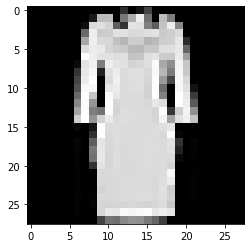

In [4]:
plt.imshow(X_train[4,:,:], cmap="gray")
plt.show()

## Model

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var / 2) + mean

In [6]:
class VAE(Model):
    def __init__(self,codings_size=20):
        super(VAE, self).__init__()
        self.n_pixels = 28*28
        self.codings_size = codings_size
        self.encoder = self.getEncoder()
        self.decoder = self.getDecoder()
        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.round_acc = keras.metrics.BinaryAccuracy(name="rounded_acc")
        self.loss_tracker = keras.metrics.Mean(name="loss")
    
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def getEncoder(self):
        inputs = keras.layers.Input(shape=[28, 28])
        z = keras.layers.Flatten()(inputs)
        z = keras.layers.Dense(150, activation="selu")(z)
        z = keras.layers.Dense(100, activation="selu")(z)
        codings_mean = keras.layers.Dense(self.codings_size)(z)
        codings_log_var = keras.layers.Dense(self.codings_size)(z)
        codings = Sampling()([codings_mean, codings_log_var])
        encoder = keras.models.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
        return encoder

    def getDecoder(self):
        decoder_inputs = keras.layers.Input(shape=[self.codings_size])
        x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
        x = keras.layers.Dense(150, activation="selu")(x)
        x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
        outputs = keras.layers.Reshape([28, 28])(x)
        decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
        return decoder
    
    def latentLoss(self,z_mean,z_var):
        latent_loss = 1+z_var-tf.math.exp(z_var)-tf.math.square(z_mean)
        latent_loss = -0.5 * tf.math.reduce_sum(latent_loss,axis=-1)
        latent_loss = tf.math.reduce_mean(latent_loss)/self.n_pixels    
        return latent_loss
            
    def reconLoss(self,X,xh):
        recon_loss = self.bce(X,xh)
        return recon_loss

    def train_step(self, data):
        X, y = data

        with tf.GradientTape() as tape:
            z_mean, z_var, zh = self.encoder(X)
            xh = self.decoder(zh)
            
            # Latent loss 
            latent_loss = self.latentLoss(z_mean,z_var)
            
            # Reconstruction loss
            recon_loss = self.reconLoss(X,xh) 

            loss = recon_loss+latent_loss
            self.loss_tracker.update_state(loss)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.round_acc.update_state(tf.round(X), tf.round(xh))
        
        # Return a dict mapping metric names to current value   
        results = {"round_acc": self.round_acc.result()}
        results["loss"] = self.loss_tracker.result()
        return results
    
    def test_step(self, data):
        X, _ = data
        z_mean, z_var, zh = self.encoder(X)
        xh = self.decoder(zh)
            
        # Latent loss 
        latent_loss = self.latentLoss(z_mean,z_var)
            
        # Reconstruction loss
        recon_loss = self.reconLoss(X,xh) 
            
        loss = recon_loss+latent_loss
        self.loss_tracker.update_state(loss)
            
        self.round_acc.update_state(tf.round(X), tf.round(xh))  
        results = {"round_acc": self.round_acc.result()}
        results["loss"] = self.loss_tracker.result()
        return results

## Fit model

In [7]:
model = VAE(codings_size=20)
model.compile(optimizer="rmsprop")
history = model.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
469/469 [==============================] - 4s 7ms/step - round_acc: 0.8231 - loss: 0.3881 - val_round_acc: 0.8679 - val_loss: 0.3506
Epoch 2/25
469/469 [==============================] - 2s 5ms/step - round_acc: 0.8759 - loss: 0.3448 - val_round_acc: 0.8835 - val_loss: 0.3345
Epoch 3/25
469/469 [==============================] - 2s 5ms/step - round_acc: 0.8871 - loss: 0.3344 - val_round_acc: 0.8911 - val_loss: 0.3346
Epoch 4/25
469/469 [==============================] - 2s 5ms/step - round_acc: 0.8934 - loss: 0.3289 - val_round_acc: 0.8961 - val_loss: 0.3254
Epoch 5/25
469/469 [==============================] - 2s 5ms/step - round_acc: 0.8977 - loss: 0.3254 - val_round_acc: 0.8996 - val_loss: 0.3212
Epoch 6/25
469/469 [==============================] - 2s 5ms/step - round_acc: 0.9007 - loss: 0.3230 - val_round_acc: 0.9022 - val_loss: 0.3197
Epoch 7/25
469/469 [==============================] - 2s 5ms/step - round_acc: 0.9031 - loss: 0.3211 - val_round_acc: 0.9042 - val_loss:

## Sample model

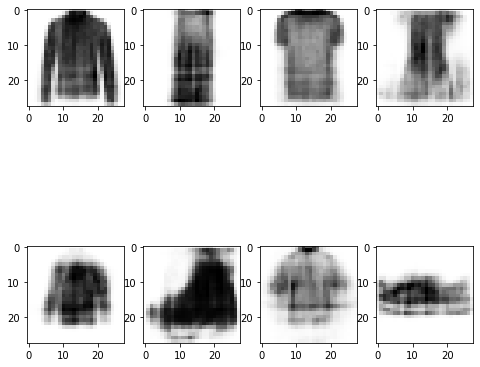

In [8]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    codings = tf.random.normal(shape=[1, 20])
    images = model.decoder(codings).numpy()
    plt.imshow(images[0,:,:], cmap="binary")
plt.show()